# GPyOpt: configuring Scikit-learn methods for mixed typed parameters optimisation

### Written by Hanting Xie, Amazon Game Studios.

*Last updated Thursday, 21 September 2017.*

The goal of this notebook is to use GPyOpt to tune the parameters of Machine Learning algorithms. In particular, we will shows how to tune the hyper-parameters for the [GradientBoostingClassifier](http://luthuli.cs.uiuc.edu/~daf/courses/optimization/papers/2699986.pdf) implemented in [Scikit-learn](http://scikit-learn.org/stable/). Given the standard interface of Scikit-learn, other models can be tuned in a similar fashion. 

We start loading the requires modules.

In [1]:
% pylab inline
import GPyOpt
import numpy as np
from matplotlib.colors import ListedColormap
from numpy.random import seed, shuffle
from sklearn.datasets import load_iris
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder

seed(12345)


Populating the interactive namespace from numpy and matplotlib


/Volumes/Unix/environments/gpyopt_env/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In this example, we will use the [iris dataset](http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) available in Scikit-learn. This dataset is a multi-class classification problem.

We split the original dataset into the training data (first 130 data points) and testing data (last 20 data points). There are 3 features that can be used for training the classifier, however, to visualise the decision boundry, we are only going to use 2 of them in this example. The performance of the classifier is evaluated in terms of the *confusion matrix* on the testing data.

In [2]:
# Let's load the dataset
x, y = load_iris(return_X_y=True)
idx = np.arange(x.shape[0])
shuffle(idx)
x = x[idx]
y = y[idx]
split_index = 20
train_x = x[:-split_index, [0, 2]]
train_y = y[:-split_index]
test_x = x[-split_index:, [0, 2]]
test_y = y[-split_index:]


Let's first see the results with the default random forest parameters. In this example, we plan to tune three parameters, they are:'learning_rate', 'max_depth', 'criterion'.
Please refer to [the documentation](http://luthuli.cs.uiuc.edu/~daf/courses/optimization/papers/2699986.pdf) to figure out the meanings of them.

In [3]:
clf = GradientBoostingClassifier()
clf.fit(train_x, train_y)
print("The default parameters obtained: \n "
      "learning_rate: {}, max_depth: {}, criterion: {}".format(
    clf.learning_rate, clf.max_depth, clf.criterion))

The default parameters obtained: 
 learning_rate: 0.1, max_depth: 3, criterion: friedman_mse


We will plot the decision boundry to visuliase how the classifier is deciding the result. 
To start with, let's define few functions to help us for the visualisation. (functions adapted from [Scikit learn example](http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html)) 

In [4]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

Let's draw the decision boundrary for the GradientBoostClassifier with the default settings.

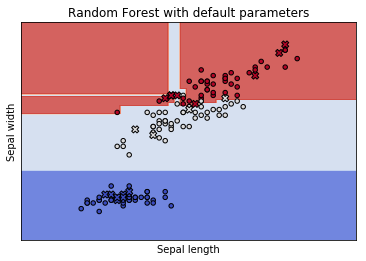

In [5]:
figure, sub = subplots(1, 1)
ax = plt.gca()
subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = train_x[:, 0], train_x[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy,
              cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=train_y, cmap=plt.cm.coolwarm, s=20,
           edgecolors='k')
ax.scatter(test_x[:, 0], test_x[:, 1], c=test_y, marker='X',
           cmap=plt.cm.coolwarm, s=50,
           edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel('Sepal length')
ax.set_ylabel('Sepal width')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title("Random Forest with default parameters")


Looks not bad, let's get the confusion matrix first to confirm our observations.

In [6]:
preds = clf.predict(test_x)
print("The confusion matrix we get is: \n{}".format(
    classification_report(test_y, preds)))

The confusion matrix we get is: 
             precision    recall  f1-score   support

          0       1.00      1.00      1.00         7
          1       0.43      0.75      0.55         4
          2       0.83      0.56      0.67         9

avg / total       0.81      0.75      0.76        20



# GPyOpt
Now let's try to apply Bayesian Optimization for the same problem. We first need to define the search space. For demo purposes, we will use three different typed parameters and show how you can handle them.

In [7]:
# Because that the categorical type of GPyOpt only support numerical input,
# at the moment, we need to encode string types categories into numeric values.
label_encoder_dict = dict()  # For recovery all encoded strings later on
criterion_choices = ('friedman_mse', 'mse', 'mae')
criterion_encoder = LabelEncoder().fit(criterion_choices)

label_encoder_dict['criterion'] = criterion_encoder

domain = [
    # this is a continuous typed parameter, you can simply give the range
    {'name': "learning_rate", 'type': 'continuous', 
     'domain': (1e-2, 2e-1)},
    # this is a discrete typed parameter, you should give all the options
    {'name': 'max_depth', 'type': 'discrete',
     'domain': (2,3,4,5)},
    # this is a categorical typed parameter, similar to discrete type,
    # you should give all the options. 
    # Please note if your options are string typed,
    # you need to encod ethem before passing in.
    {'name': 'criterion', 'type': 'categorical',
     'domain': tuple(criterion_encoder.transform(criterion_choices))}]


GPyOpt gives back suggestions in a list typed format. We can convert them back to dict type for easier assiginment to scikit-learn models.

In [8]:
def recover_parameter(input_parameters):
    """
    Note that this function can be used in most cases for the following 
    three purposes:
    1. It will convert the parameter list to a dict for easier 
    connection to scikit-learn
    2. It will converting encoded categorical type back to strings 
    given the encode dict we defined before
    3. It will try to convert float types numbers back to int as GPyOpt current
    covert all int to floats for optimisation.
    
    :param input_parameters: The parameters suggested by GPyOpt
    :return: The converted parameter dictionary
    """
    parameter_names = [parameter["name"] for parameter in domain]
    parsed_param_dict = dict()
    if input_parameters.ndim > 1:
        input_parameters = input_parameters[0]
    for i, parameter_name in enumerate(parameter_names):
        if parameter_name in label_encoder_dict:
            parsed_param_dict[parameter_name] = label_encoder_dict[
                parameter_name].inverse_transform(int(input_parameters[i]))
        else:
            if input_parameters[i].is_integer():
                parsed_param_dict[parameter_name] = int(input_parameters[i])
            else:
                parsed_param_dict[parameter_name] = input_parameters[i]
    return parsed_param_dict


Now, we just need to defined an objective function to give reward/loss to the GPyOpt optimiser.

In [9]:
def objective(params):
    # A general objective function for scikit-learn classifiers or regressors
    params = recover_parameter(params)  # Recover parameters
    classifier = GradientBoostingClassifier()  # Create a new instance for tune
    classifier.set_params(**params)  # Assign parameters
    # We use cross validation to get the current score from the parameter
    cv_producer = StratifiedKFold(
        n_splits=3, shuffle=True)
    cv_score = - cross_val_score(classifier, train_x, train_y,
                                 scoring='neg_log_loss',
                                 cv=cv_producer, n_jobs=-1).mean()
    return cv_score


We, then, create the GPyOpt object and run the optimization procedure. It might take a while.

In [10]:
b_opt = GPyOpt.methods.BayesianOptimization(f=objective,
                                            # function to optimize
                                            domain=domain,
                                            initial_design_numdata=10,
                                            # Exploration exploitation
                                            exact_feval=True)

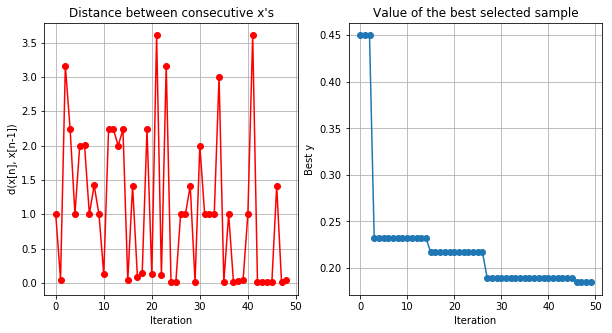

In [11]:
# it may take a few minutes
b_opt.run_optimization(max_iter=40)
b_opt.plot_convergence()

Let's show the best parameters found. They differ significantly from the default parameters.

In [12]:
# get the best parameters
best_params = b_opt.X[np.argmin(b_opt.Y)]
best_params = recover_parameter(best_params)
print("best parameters are {}".format(best_params))
clf = GradientBoostingClassifier()
clf.set_params(**best_params)
clf.fit(train_x, train_y)

best parameters are {'learning_rate': 0.027860111441686413, 'max_depth': 2, 'criterion': 'mse'}


GradientBoostingClassifier(criterion='mse', init=None,
              learning_rate=0.027860111441686413, loss='deviance',
              max_depth=2, max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

Let's now draw the decision boundry for the optimised classifier.

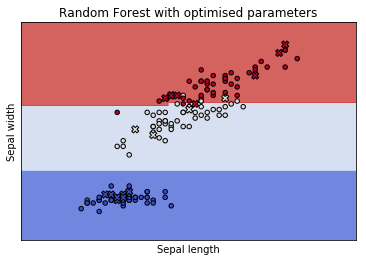

In [13]:
# Set-up 2x2 grid for plotting.
figure, sub = plt.subplots(1, 1)
ax = plt.gca()
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = train_x[:, 0], train_x[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy,
              cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=train_y, cmap=plt.cm.coolwarm, s=20,
           edgecolors='k')
ax.scatter(test_x[:, 0], test_x[:, 1], c=test_y, marker='X', cmap=plt.cm.coolwarm, s=50,
           edgecolors='k')

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel('Sepal length')
ax.set_ylabel('Sepal width')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title("Random Forest with optimised parameters")


The result looks very good now! Let's check its confusion matrix.

In [14]:
preds = clf.predict(test_x)
print("The confusion matrix we get is: \n{}".format(
    classification_report(test_y, preds)))


The confusion matrix we get is: 
             precision    recall  f1-score   support

          0       1.00      1.00      1.00         7
          1       0.75      0.75      0.75         4
          2       0.89      0.89      0.89         9

avg / total       0.90      0.90      0.90        20



Comparing to the default classifier, all three measurements have been significantly improved!